## TSNE Tutorial
### Vizualizing & Exploring High-Dimensional Data in 2D/3D 
___
TSNE Overview
- *T-distributed stochastic neighbor embedding* (TSNE) is a learning-based dimensionality reduction algorithm.
- TSNE learns a model such that vectors close in embedding space will be close in 2D/3D space. 
- Two-stage algorithm:
    1. Constructs probability distribution over pairs of high-dimensional objects such that similair points are assigned high probability.
    2. Uses gradient descent and KL-divergence metric to generate a similair distribution in 2D/3D space.  
    
*Read more about TSNE [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)*
___

### Import Dependencies

*suggested env:*
```
python3 -m venv venv
source venv/bin/activate
pip3 install numpy pandas matplotlib sentence-transformers keras datasets scikit-learn
```

In [ ]:
# data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer,util

# dataset
from keras.datasets import mnist
import datasets as ds

# TSNE tool
from sklearn.manifold import TSNE

# ipython magic
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

### Demo 1: TSNE for MNIST dataset
___
### Data Loading
- TSNE needs $N \times M$ matrix as input. 
    - Given dataset $x \in \mathbb{R}^{28 \times 28}$, $y \in \mathbb{R}$
    - Flatten so $x' \in \mathbb{R}^{784}$ (x is vector)

Original X_i shape: (60000, 28, 28)


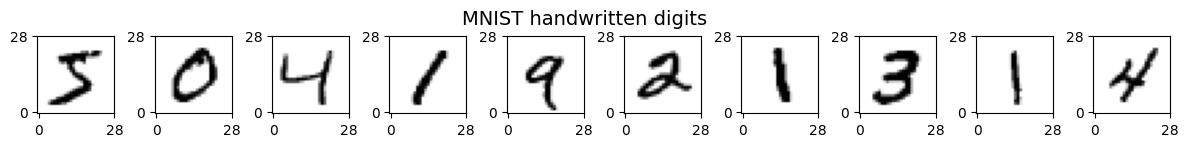

Flattened X_i shape: (60000, 784)


In [2]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# vizualize few datapoints
fig, ax = plt.subplots(1, 10, figsize=(15, 1), gridspec_kw=dict(hspace=0.2, wspace=0.1))
for i in range(10):
    ax[i].imshow(x_train[i][::-1,:], cmap='gray_r')
    ax[i].set_xticks([0,28])
    ax[i].set_yticks([0,28]), ax[i].invert_yaxis()
print(f"Original X_i shape: {x_train.shape}")
plt.suptitle('MNIST handwritten digits', position=(0.5, 1.15), fontsize=14)
plt.show()

# flatten data
X = np.array([x_train[i].flatten() for i in range(x_train.shape[0])])
print(f"Flattened X_i shape: {X.shape}")

### Next, let's use dataframe for easier datahandling
- Load X,Y into df
- Random sample $10\%$ of data. 
    - TSNE is $O(n^2)$ so this step is helpful for inital exploration. 

In [3]:
df = pd.DataFrame(X)
df['label'] = pd.DataFrame(y_train)
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
df.shape

(6000, 785)

### Run TSNE
- Init TSNE engine with parameters.
    - `n_iters:int`: number of epochs for TSNE
    - `n_components:int`: reduced dimension (2D or 3D)
    - `perplexity:int`: How many neighbors are considered for TSNE algorithm. 
    - `early_exaggeration:int`: Distance of clusters in 2D space.
    - `random_state:int`: RNG seed for reproducible results 
- Run TSNE fitting algorithm.

In [4]:
engine = TSNE(n_iter=300, n_components=2, perplexity=30, random_state=42)
tsne_results = engine.fit_transform(df.values)
tsne_results.shape

(6000, 2)

### Plot TSNE results 

/tmp/ipykernel_108140/2394446547.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


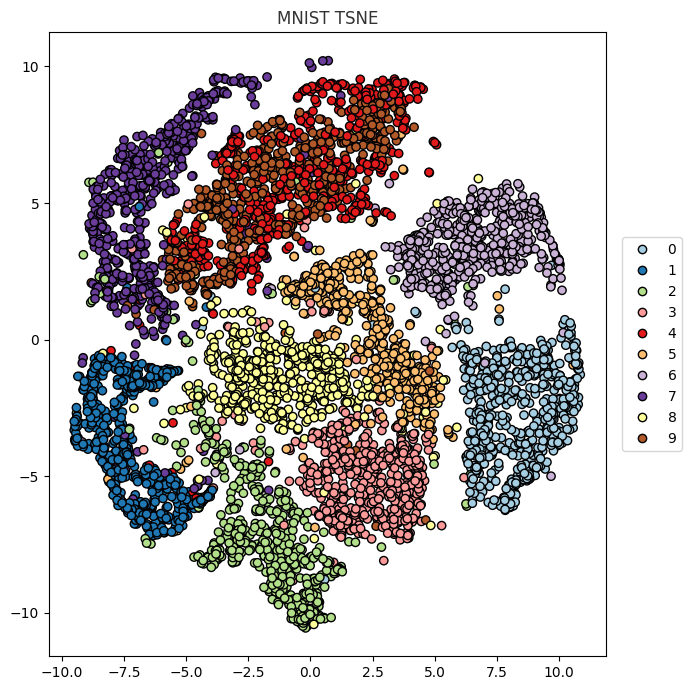

In [5]:
fig = plt.figure( figsize=(7,7) )
ax = fig.add_subplot(1, 1, 1, title='TSNE')
scatter = ax.scatter(
    tsne_results[:,0], 
    tsne_results[:,1], 
    c=df['label'], 
    cmap=plt.colormaps['Paired'], 
    alpha=1.0,
    edgecolor='black')

# STYLING
t = ax.set_title("MNIST TSNE", alpha=.8, clip_on=False, y=1)
leg = ax.legend(*scatter.legend_elements(num=10), loc="right", bbox_to_anchor=(1.15, 0.5), )
for lh in leg.legendHandles: 
    lh.set_markeredgecolor('black')
plt.tight_layout()
plt.show()

## Demo 2: TSNE for Text Data
___

### Load and process dataset.
- We will use `goemotions` dataset that can be found [here](https://huggingface.co/datasets/go_emotions)
- Dataset description: 
    - $X:=$ sentences.
    - $Y:=$ emotion category where $y \in$ `('amusement', 'curiosity', 'confusion', 'joy', 'fear', 'sadness', 'anger')`.


In [6]:
dataset = ds.load_dataset("go_emotions", "simplified")
df = pd.DataFrame(dataset['train'])
df = df[df['labels'].map(len) == 1]
df['labels'] = df['labels'].apply(lambda x: x[0])
EMOTION_MAP={1: 'amusement', 7: 'curiosity', 6: 'confusion', 17: 'joy', 14: 'fear', 25: 'sadness', 2: 'anger'}
EMOTION_LIST=list(EMOTION_MAP.values())
df = df[df['labels'].isin(list(EMOTION_MAP.keys()))]
df['labels'] = df['labels'].apply(lambda x: EMOTION_MAP[x])
df['labels'] = df['labels'].apply(lambda x: EMOTION_LIST.index(x))
df.shape

(7024, 3)

### Get embeddings of data points.
- TSNE needs $N \times M$ matrix as input. 
- Currently we have $N$ samples of variable length sentences.
- Let's use generic text embedding model `all-MiniLM-L6-v2` to get uniform representation of sentences. ([Model info](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)) 
    - We project sentences to embedding space where nearby points are *semantically* similair

In [7]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['text'].values, convert_to_tensor=True)
embeddings.shape

torch.Size([7024, 384])

### Run TSNE
- Same as before, we initialize TSNE engine and run `fit_transform` function.

In [8]:
engine = TSNE(n_components=2, n_iter=1000, perplexity=25, early_exaggeration=25, random_state=42)
tsne_embs = engine.fit_transform(embeddings.cpu().detach().numpy())
tsne_embs.shape

(7024, 2)

### Plot TSNE Embeddings
- We can see the plot is not as good as MNIST data.
- Training a custom classifier would learn better embedding and generate cleaner plot.

<Figure size 640x480 with 0 Axes>

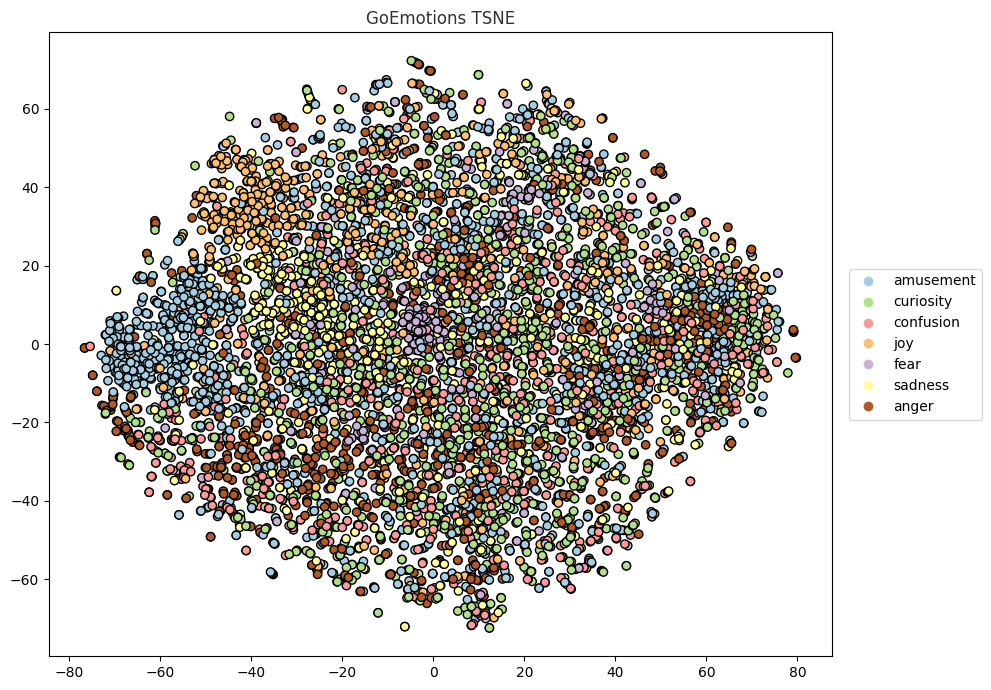

In [9]:
plt.clf()
fig = plt.figure( figsize=(10,7) )
ax = fig.add_subplot(1, 1, 1, title='TSNE',)
scatter = ax.scatter(
    x=tsne_embs[:,0], 
    y=tsne_embs[:,1], 
    c=df['labels'], 
    cmap=plt.colormaps['Paired'],
    alpha=1.0,
    edgecolor='black')
t = ax.set_title("GoEmotions TSNE", alpha=.8, clip_on=False, y=1)
leg = ax.legend(*scatter.legend_elements(num=7), loc="right", bbox_to_anchor=(1.2, 0.5), )
for i,v in enumerate(EMOTION_LIST):
    leg.get_texts()[i].set_text(v)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

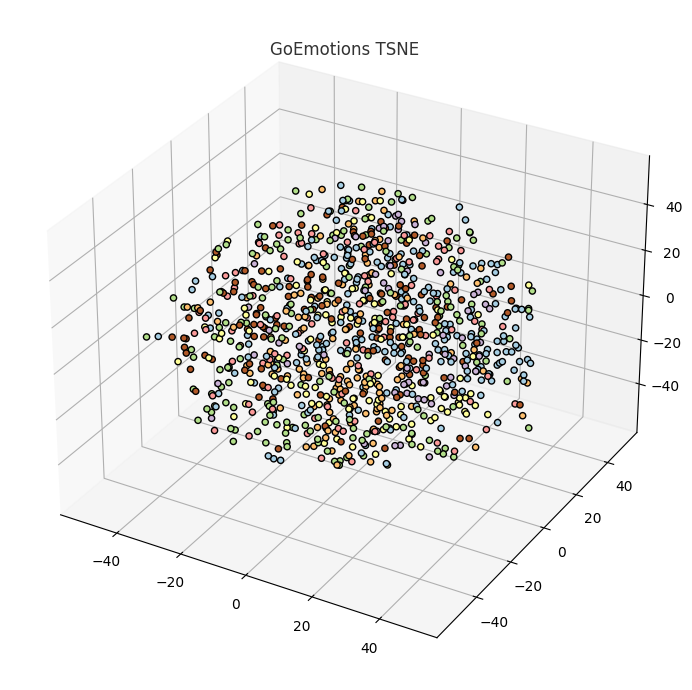

In [10]:
engine = TSNE(n_components=3, n_iter=1000, perplexity=25, early_exaggeration=25, random_state=42)
tsne_embs = engine.fit_transform(embeddings.cpu().detach().numpy()[:1000])
tsne_embs.shape

plt.clf()
fig = plt.figure( figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, title='TSNE',projection='3d' )
scatter = ax.scatter(
    tsne_embs[:,0], 
    tsne_embs[:,1], 
    tsne_embs[:,2], 
    c=df['labels'][:1000], 
    cmap=plt.colormaps['Paired'],
    alpha=1.0,
    edgecolor='black')
t = ax.set_title("GoEmotions TSNE", alpha=.8, clip_on=False, y=1)
# leg = ax.legend(*scatter.legend_elements(num=7), loc="right", bbox_to_anchor=(1.2, 0.5), )
# for i,v in enumerate(EMOTION_LIST):
#     leg.get_texts()[i].set_text(v)
plt.tight_layout()
plt.show()

# References:
- TSNE Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
- Tutorial: https://builtin.com/data-science/tsne-python
- Tutorial: https://www.datacamp.com/tutorial/introduction-t-sne
- Tutorial: https://danielmuellerkomorowska.com/2021/01/05/introduction-to-t-sne-in-python-with-scikit-learn/
- TSNE Theory: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding